In [1]:
using DrWatson
@quickactivate "Simulation"
include(srcdir("TienGordon.jl"))

import .TienGordon as TG
using CairoMakie
using ProgressMeter
using ColorSchemes
using Statistics

Threads.nthreads()

  Activating project at `~/Documents/p5control-bluefors-evaluation/simulation`


10

In [2]:
TG.ν = 15E9
TG.Δ = 189e-6
τ = TG.set_τ(0.51)
TG.n = 40
TG.m = 1

V₀ = TG.V0;
Vω = collect(0:0.01:25);

In [3]:
z = Matrix{Float64}(undef, length(V₀), length(Vω))
progress = Progress(length(Vω), 1, "Working...")
Threads.@threads for i in 1:lastindex(Vω)
    next!(progress)
    z[:, i] = TG.IV₀.(V₀, Vω[i])
end

dz = Matrix{Float64}(undef, length(V₀) - 1, length(Vω))
for i in 1:lastindex(Vω)
    dz[:, i] = diff(z[:, i]) ./ diff(V₀)
end

Working... 100%|█████████████████████████████████████████| Time: 0:01:10


In [4]:
clim = (mean(filter(!isnan, dz)) - std(filter(!isnan, dz)), 
        mean(filter(!isnan, dz)) + std(filter(!isnan, dz)));
see = get(ColorSchemes.ice, range(0.0, 1.0, length=512))

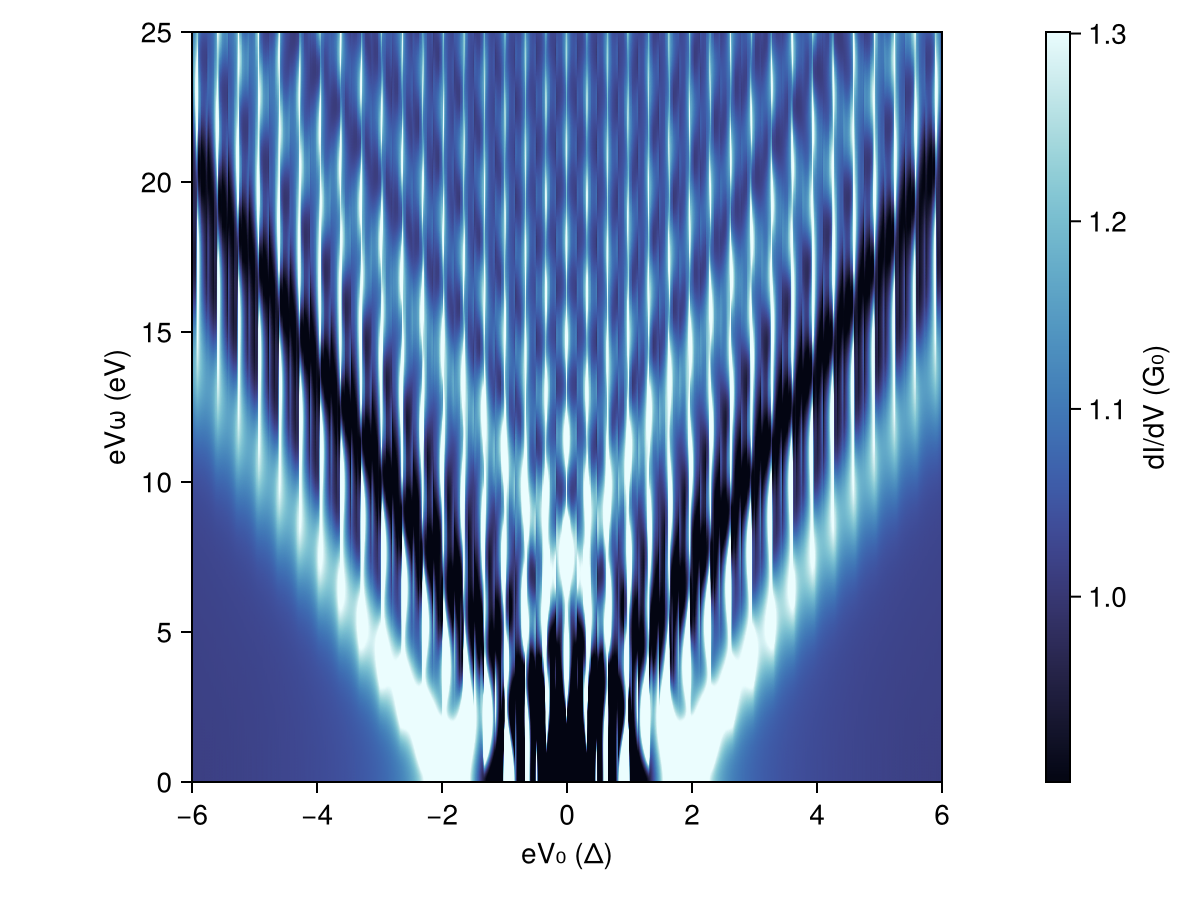

CairoMakie.Screen{IMAGE}


In [5]:
fig = Figure()
ax = Axis(fig[1, 1], aspect=1)

plt = heatmap!(ax, V₀[1:end-1], Vω, dz, colorrange=clim,colormap=see)
Colorbar(fig[1, 2], plt, label="dI/dV (G₀)")
ax.xlabel = "eV₀ (Δ)"
ax.ylabel = "eVω (eV)"
ax.limits = (V₀[1], V₀[end]), (Vω[1], Vω[end])

display(fig)

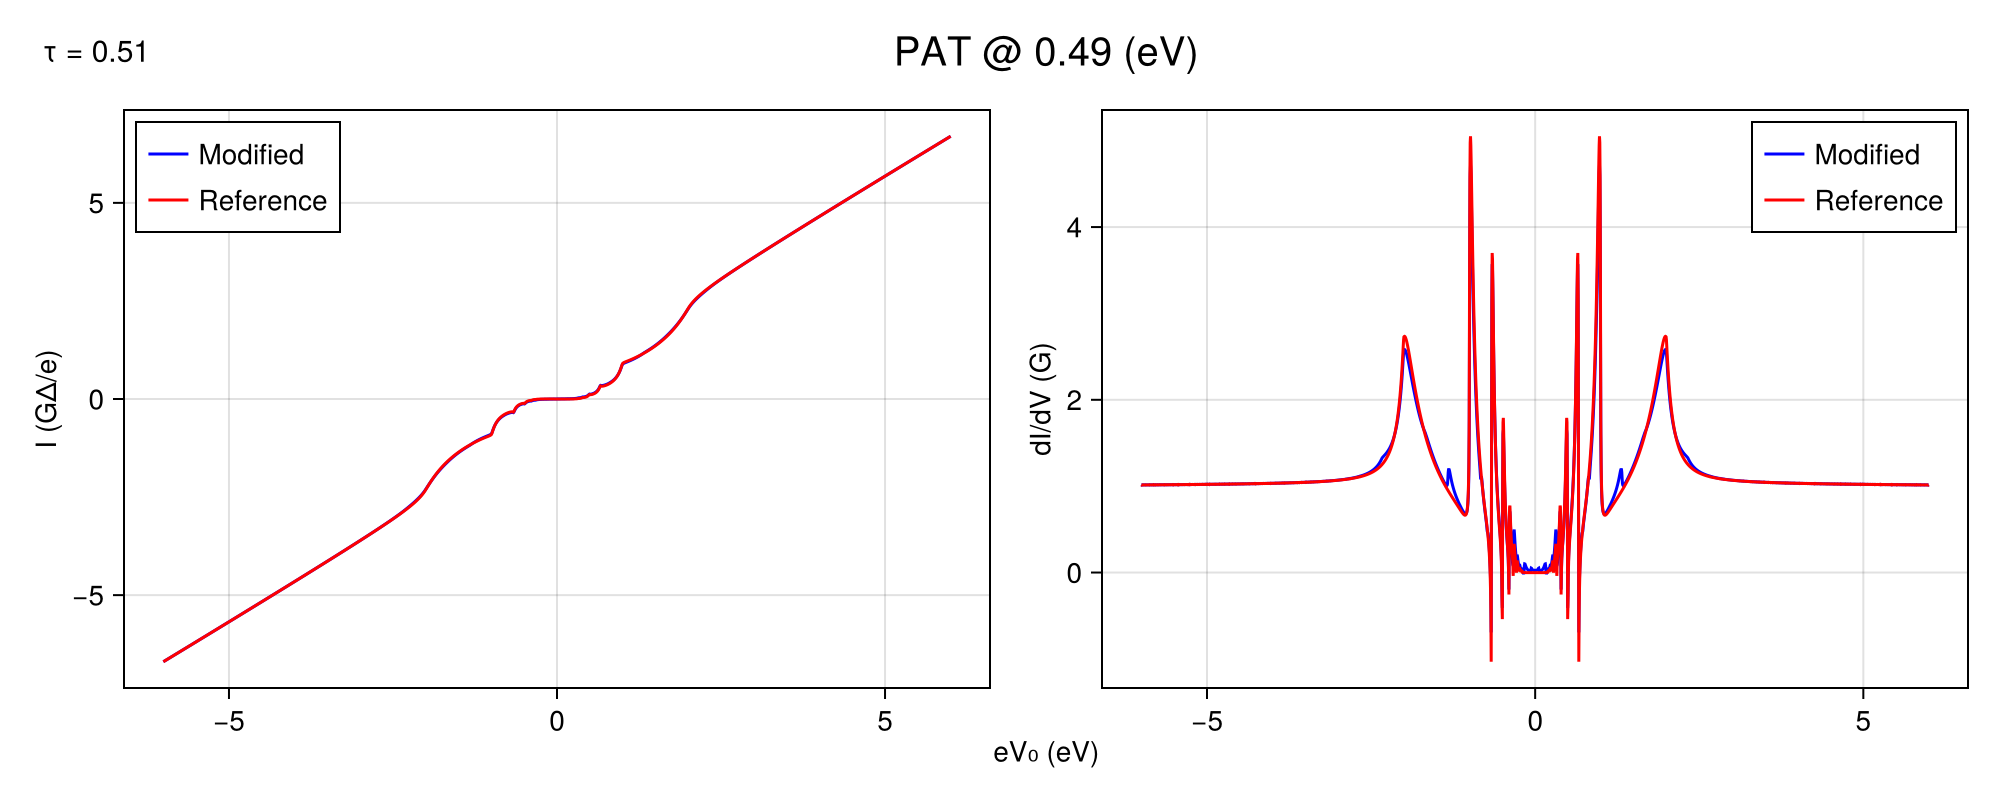

CairoMakie.Screen{IMAGE}


In [6]:
ref_V0, ref_I0 = TG.V0, TG.I0

evolution = 50

fig = Figure(size = (1000, 400))

ax = Axis(fig[1, 1])

lines!(ax, V₀[1:end], z[:, evolution], color = :Blue, label = "Modified")
lines!(ax, ref_V0, ref_I0, color = :Red, label = "Reference")
axislegend(ax, position=:lt)
ax.ylabel = "I (GΔ/e)"

ax = Axis(fig[1, 2])
lines!(ax, V₀[1:end-1], dz[:, evolution], color = :Blue, label = "Modified")
lines!(ax, ref_V0[1:end-1], diff(ref_I0) ./ diff(ref_V0), color = :Red, label = "Reference")
axislegend(ax)
ax.ylabel = "dI/dV (G)"

Label(fig[0, 1:2], "PAT @ $(Vω[evolution]) (eV)", fontsize=20)
Label(fig[0, 1:2], "τ = $(τ)", fontsize=15, padding = (-950, 0, 0, 0))
Label(fig[2, 1:2], "eV₀ (eV)", padding = (0, 0, 0, -20))

display(fig)